<a href="https://colab.research.google.com/github/chemjen/cats_dogs_CV/blob/master/cats_dogs_lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Run this cell to connect to Google GPU, but first:
## Go to Edit > Notebook Settings, and then select GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing import image
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
# Construct the path
projectdir = "./drive/My Drive/cats_dogs_CV/"
datadir = projectdir + "data/"
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/' 

In [0]:
## the images will be resized to (image_width x image_height)
image_width = 150
image_height = 150
image_size = (image_width, image_height)

## load in 20-image size batches so as not to kill memory
batch_size = 20

In [6]:
# All images will be rescaled by 1./255 --> A byte is 2^8 = 256
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        traindir, # directory
        target_size=image_size, #resize
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validdir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [0]:
## create Neural Net like LeNet model

## Sequential() object for sequential layers
lenet_model = Sequential()

## first layer: convolutional layer with 6 nodes and 5x5 kernel
lenet_model.add(Conv2D(6, (5, 5), activation='relu', name='conv1',
                        input_shape=(150, 150, 3)))
## second layer: subsampling with max pooling --> halve the size so (2,2) kernel
lenet_model.add(MaxPooling2D((2, 2), name='pool1'))

## third layer: another 5X5 convolution into 16 nodes
lenet_model.add(Conv2D(16, (5, 5), activation='relu', name='conv2'))

## fourth layer: maxpooling --> end up with 
lenet_model.add(MaxPooling2D((2, 2), name='pool2'))

## output is flatten()ed before put into fully-connected layers
lenet_model.add(Flatten(name='flatten'))

## fully connected layers are called "Dense" in Keras (Dense refers to hidden layers)
lenet_model.add(Dense(120, activation='relu', name='fc1'))
lenet_model.add(Dense(84, activation='relu', name='fc2'))

## final layer is of size 1, because binary classifier (0=cats, 1=dogs)
lenet_model.add(Dense(1, activation='sigmoid', name='predictions'))

In [8]:
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 146, 146, 6)       456       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 73, 73, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 69, 69, 16)        2416      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 34, 34, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 120)               2219640   
_________________________________________________________________
fc2 (Dense)                  (None, 84)               

In [0]:
lenet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [10]:
best_model = ModelCheckpoint(projectdir+"lenet/cats_and_dogs_lenet.h5", monitor='val_loss', verbose=0, save_best_only=True)

history = lenet_model.fit_generator(
        train_generator,
        steps_per_epoch=100, #2000/20 20 is the batch size
        validation_steps=8, #160/20
        epochs=10,
        validation_data=validation_generator,
        callbacks=[best_model, TensorBoard(log_dir=projectdir+'/lenet/logs')])

Epoch 1/10
  2/100 [..............................] - ETA: 20:29 - loss: 0.6498 - accuracy: 0.6500

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.245665). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 62/100 [=================>............] - ETA: 8:09 - loss: 0.6964 - accuracy: 0.5382

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 90 could not be retrieved. It could be because a worker has died.
  UserWarning)


 92/100 [==========================>...] - ETA: 1:50 - loss: 0.6914 - accuracy: 0.5563

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 62 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/100 [==============================] - 1399s 14s/step - loss: 0.6894 - accuracy: 0.5593 - val_loss: 0.6652 - val_accuracy: 0.5250
Epoch 2/10
100/100 [==============================] - 21s 209ms/step - loss: 0.6142 - accuracy: 0.6739 - val_loss: 0.5768 - val_accuracy: 0.6062
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.4724 - accuracy: 0.7789 - val_loss: 0.5702 - val_accuracy: 0.6250
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 0.3357 - accuracy: 0.8543 - val_loss: 0.9805 - val_accuracy: 0.6250
Epoch 5/10
100/100 [==============================] - 11s 106ms/step - loss: 0.1772 - accuracy: 0.9337 - val_loss: 0.5182 - val_accuracy: 0.6125
Epoch 6/10
100/100 [==============================] - 11s 107ms/step - loss: 0.1244 - accuracy: 0.9548 - val_loss: 1.5004 - val_accuracy: 0.6000
Epoch 7/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0698 - accuracy: 0.9754 - val_loss: 1.0593 - val_accuracy: 0.6

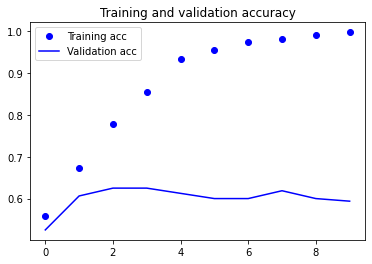

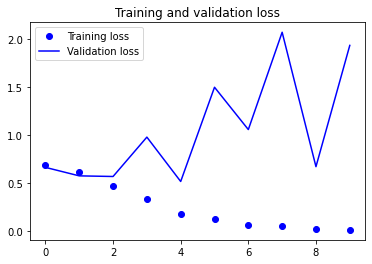

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## This is overfitting -- 
solutions to overfitting: dropout, regularization, and __image augmentation__

In [0]:
## image augmentation
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

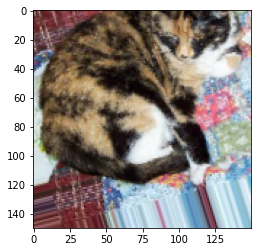

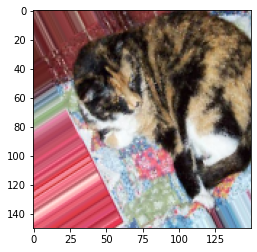

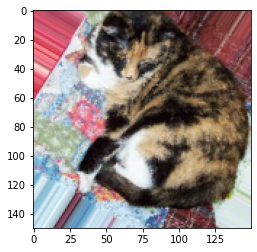

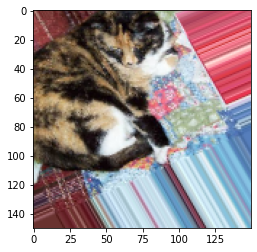

In [13]:
fnames = [os.path.join(testdir, fname) for fname in os.listdir(testdir)]

# We pick one image to "augment"
img_path = fnames[5]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3) because the flow method requires the input array to be of rank 4
x = np.expand_dims(x, axis=0)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

In [14]:
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        traindir, 
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set
validation_generator = validation_datagen.flow_from_directory(
        validdir,  
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

Found 2010 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [0]:
## because the augmented images are highly correlated, there is still a good likelihood of overfitting
## add a dropout layer to the NN to help with overfitting, with 50% probability

lenet_model = Sequential()
lenet_model.add(Conv2D(6, (5, 5), activation='relu',name='conv1',
                        input_shape=(150, 150, 3)))
lenet_model.add(MaxPooling2D((2, 2), name='pool1'))
lenet_model.add(Conv2D(16, (5, 5), activation='relu', name='conv2'))
lenet_model.add(MaxPooling2D((2, 2), name='pool2'))
lenet_model.add(Flatten(name='flatten'))
# The new dropout layer
lenet_model.add(Dropout(0.5))
lenet_model.add(Dense(120, activation='relu', name='fc1'))
lenet_model.add(Dense(84, activation='relu', name='fc2'))
lenet_model.add(Dense(1, activation='sigmoid', name='predictions'))

lenet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
best_model = ModelCheckpoint(projectdir+"lenet/cats_and_dogs_lenet.h5", monitor='val_loss', verbose=0, save_best_only=True)

history = lenet_model.fit_generator(
        train_generator,
        steps_per_epoch=101, #2000/20 20 is the batch size
        validation_steps=8, #160/20
        epochs=10,
        validation_data=validation_generator,
        callbacks=[best_model, TensorBoard(log_dir=projectdir+'lenet/logs')])

Epoch 1/10
101/101 [==============================] - 21s 212ms/step - loss: 0.6954 - accuracy: 0.5284 - val_loss: 0.6964 - val_accuracy: 0.5437
Epoch 2/10
101/101 [==============================] - 21s 208ms/step - loss: 0.6882 - accuracy: 0.5582 - val_loss: 0.7016 - val_accuracy: 0.5312
Epoch 3/10
101/101 [==============================] - 21s 207ms/step - loss: 0.6857 - accuracy: 0.5517 - val_loss: 0.8217 - val_accuracy: 0.5562
Epoch 4/10
101/101 [==============================] - 21s 207ms/step - loss: 0.6794 - accuracy: 0.5746 - val_loss: 0.7134 - val_accuracy: 0.5938
Epoch 5/10
101/101 [==============================] - 21s 206ms/step - loss: 0.6738 - accuracy: 0.5781 - val_loss: 0.6308 - val_accuracy: 0.6000
Epoch 6/10
101/101 [==============================] - 21s 206ms/step - loss: 0.6670 - accuracy: 0.5856 - val_loss: 0.7254 - val_accuracy: 0.5938
Epoch 7/10
101/101 [==============================] - 21s 206ms/step - loss: 0.6559 - accuracy: 0.6040 - val_loss: 0.6356 - val_ac

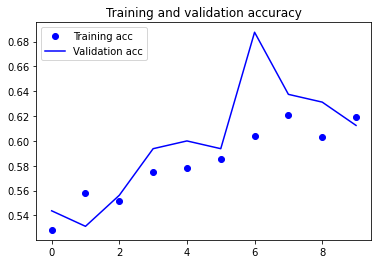

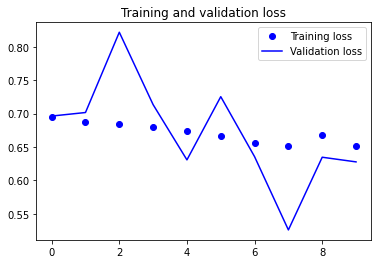

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        traindir, 
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255) # we only need to scale the input for validation set
validation_generator = validation_datagen.flow_from_directory(
        validdir,  
        target_size=image_size,  
        batch_size=batch_size,
        class_mode='binary')

Found 2010 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [0]:
lenet_model = Sequential()
lenet_model.add(Conv2D(6, (5, 5), activation='relu',name='conv1',
                        input_shape=(150, 150, 3)))
lenet_model.add(MaxPooling2D((2, 2), name='pool1'))
lenet_model.add(Conv2D(16, (5, 5), activation='relu', name='conv2'))
lenet_model.add(MaxPooling2D((2, 2), name='pool2'))
lenet_model.add(Flatten(name='flatten'))
# The new dropout layer
lenet_model.add(Dropout(0.5))
lenet_model.add(Dense(120, activation='relu', name='fc1'))
lenet_model.add(Dense(84, activation='relu', name='fc2'))
lenet_model.add(Dense(1, activation='sigmoid', name='predictions'))

lenet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
best_model = ModelCheckpoint(projectdir+"lenet/cats_and_dogs_lenet.h5", monitor='val_loss', verbose=0, save_best_only=True)

history = lenet_model.fit_generator(
        train_generator,
        steps_per_epoch=500, #2000/20 20 is the batch size
        validation_steps=8, #160/20
        epochs=10,
        validation_data=validation_generator,
        callbacks=[best_model, TensorBoard(log_dir=projectdir+'lenet/logs')])

Epoch 1/10
500/500 [==============================] - 103s 206ms/step - loss: 0.6765 - accuracy: 0.5626 - val_loss: 0.6242 - val_accuracy: 0.6375
Epoch 2/10
500/500 [==============================] - 102s 205ms/step - loss: 0.6543 - accuracy: 0.6024 - val_loss: 0.6225 - val_accuracy: 0.6375
Epoch 3/10
500/500 [==============================] - 101s 202ms/step - loss: 0.6414 - accuracy: 0.6237 - val_loss: 0.6173 - val_accuracy: 0.6313
Epoch 4/10
500/500 [==============================] - 106s 211ms/step - loss: 0.6295 - accuracy: 0.6416 - val_loss: 0.5217 - val_accuracy: 0.7375
Epoch 5/10
393/500 [======================>.......] - ETA: 22s - loss: 0.6180 - accuracy: 0.6543

KeyboardInterrupt: ignored